<a href="https://colab.research.google.com/github/CodyBurker/W266_Group_Project/blob/CodyCNNBase/CNN-word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [1]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import numpy as np

In [2]:
!git clone https://github.com/CodyBurker/W266_Group_Project

Cloning into 'W266_Group_Project'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 99 (delta 38), reused 32 (delta 5), pack-reused 0
Unpacking objects: 100% (99/99), done.
Checking out files: 100% (14/14), done.


In [5]:
def read_in_data(path="W266_Group_Project/"):
    import pandas as pd
    X_train = pd.read_csv(path + "x_train_sampled_yelp_data.csv")
    y_train = pd.read_csv(path + "y_train_sampled_yelp_data.csv")
    X_test = pd.read_csv(path + "x_test_sampled_yelp_data.csv")
    y_test = pd.read_csv(path + "y_test_sampled_yelp_data.csv")
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = read_in_data()
y_train = np.array(y_train.stars.astype('int')) - 1
y_test = np.array(y_test.stars.astype('int')) - 1

https://towardsdev.com/sentiment-analysis-with-cnn-using-keras-c4debff57fc5?gi=708b4ef40e2f

Encode text and pad it.

Word2Vec: https://machinelearningknowledge.ai/word2vec-in-gensim-explained-for-creating-word-embedding-models-pretrained-and-custom/

In [11]:
# from gensim.models import Word2Vec,KeyedVectors

In [8]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])


In [10]:
X_train['encoded'] = tokenizer.texts_to_sequences(X_train['text'])
X_test['encoded'] = tokenizer.texts_to_sequences(X_test['text'])

(array([47936., 21142.,  6699.,  2360.,   947.,   441.,   202.,   134.,
           90.,    49.]),
 array([   0.,  101.,  202.,  303.,  404.,  505.,  606.,  707.,  808.,
         909., 1010.]),
 <a list of 10 Patch objects>)

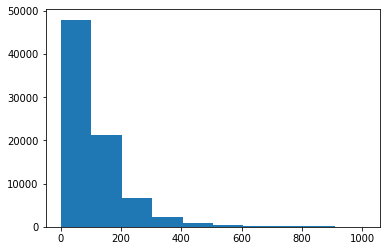

In [15]:
import matplotlib.pyplot as plt
plt.hist(X_train['encoded'].apply(len))

In [22]:
# Hyper parameters to tune later: maxlen, padding
sentence_len = 1024
X_train_encoded =  pad_sequences(X_train['encoded'], maxlen=sentence_len, padding='post', truncating='post')
X_test_encoded = pad_sequences(X_test['encoded'], maxlen=sentence_len, padding='post', truncating = 'post')
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(80000, 1024)
(20000, 1024)


Create model

New Arcitecture: https://aclanthology.org/D14-1181.pdf

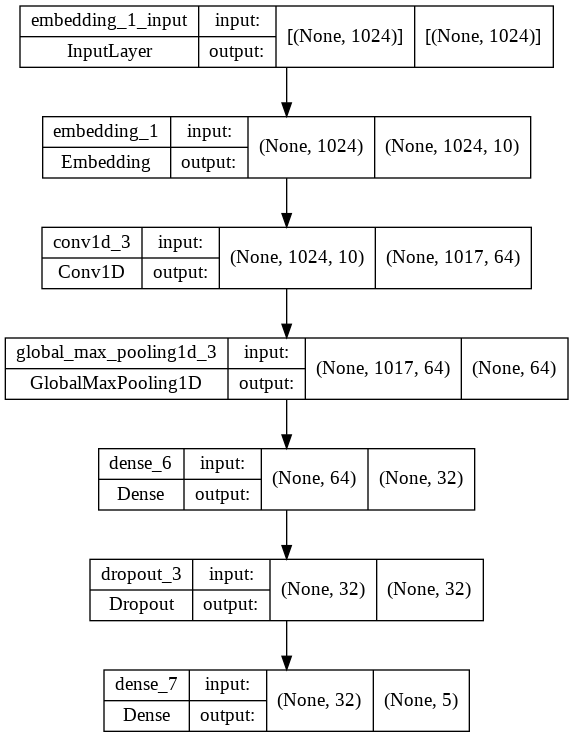

In [23]:
from keras.layers.pooling import GlobalMaxPool1D
from keras import Sequential
from keras.layers import Dense, Embedding, Activation, Dropout
from keras.layers import  MaxPool1D, GlobalMaxPool1D, Conv1D
vocab_size = len(tokenizer.word_counts)
# New model architecture
model2 = Sequential()
model2.add(Embedding(vocab_size,10, input_length = sentence_len))
model2.add(Conv1D(64,8,activation="relu"))
model2.add(GlobalMaxPool1D())
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(5,activation='softmax'))
# model2.add(Dense(1,activation='relu'))
from keras.utils.vis_utils import plot_model
model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
plot_model(model2,show_shapes=True)


In [24]:
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
callback = EarlyStopping(monitor='val_accuracy', patience=15)

history = model2.fit(X_train_encoded,y_train,
           epochs=150,
           batch_size=128, 
           validation_data = [X_test_encoded, y_test],
           callbacks = [TqdmCallback(verbose=0)],
           verbose=0,)

0epoch [00:00, ?epoch/s]

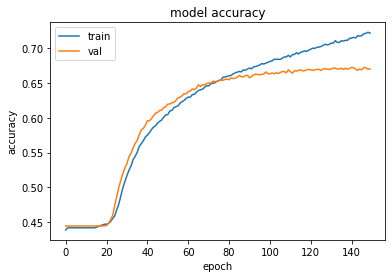

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

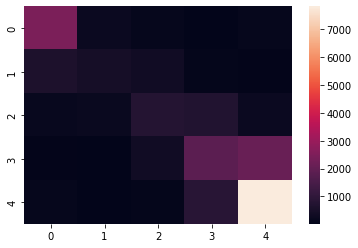

In [26]:
# Generate confusion matrix on test set
test_preds = model2.predict(X_test_encoded)
test_preds_stars = test_preds.argmax(axis=1) + 1
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test + 1, test_preds_stars)
import seaborn as sns
sns.heatmap(cf)